In [52]:
import pydub
import pandas as pd
import librosa as lb
import numpy as np
import os
import random
from linetimer import CodeTimer

In [53]:
def osPath(path):
    return os.path.abspath(path)

In [60]:
pathname = "data/data files/validated.tsv"
output_pathname = "data/data files/validated_SpeechFeatures.tsv"
os.environ["PATH"] += os.pathsep + 'FFMPEG/bin'
mp3_folder = "data/clips"
wav_folder = "data/wav_clips"

# Feature Extraction

In [61]:
df = pd.read_csv(pathname, sep="\t")
df

,client_id,path,sentence,up_votes,down_votes,age,gender,accent
0,0013037a1d45cc33460806cc3f8ecee9d536c45639ba4c...,common_voice_en_699711.mp3,She'll be all right.,2,1,NaN,NaN,NaN
1,003fb666a99eb3aa3ba05d9c8641c18e55cf7d34d1b981...,common_voice_en_17263741.mp3,Do you mean it?,2,0,NaN,NaN,NaN
2,0047f1aea3f39c4c6a9298d84f046c1f84f439f594d840...,common_voice_en_17561821.mp3,How is Mozilla going to handle ambiguities lik...,2,0,NaN,NaN,NaN
3,00610bda27826b8615139e6a430d43382935f37922dc1c...,common_voice_en_59751.mp3,I guess you must think I'm kinda batty.,2,1,NaN,NaN,NaN
4,007762ba618b38ed77739616c7a6ace0341e1e134ac405...,common_voice_en_18902772.mp3,Groves started writing songs when she was four...,2,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
644114,939991dfcf12d8250739f3b4e5ed47e0dc4bf8ffb69810...,common_voice_en_18792608.mp3,It is almost exclusively in the final version ...,2,1,twenties,male,NaN
644115,939991dfcf12d8250739f3b4e5ed47e0dc4bf8ffb69810...,common_voice_en_18792609.mp3,All songs written by Mark Greaney.,2,0,twenties,male,NaN
644116,939991dfcf12d8250739f3b4e5ed47e0dc4bf8ffb69810...,common_voice_en_18792611.mp3,Later the ninth and tenth grades were added.,2,1,twenties,male,NaN
644117,939991dfcf12d8250739f3b4e5ed47e0dc4bf8ffb69810...,common_voice_en_18792612.mp3,"Aull, who named it Quasi-Rolle theorem.",2,1,twenties,male,NaN


In [62]:
df = df.dropna(subset=["age","gender","accent"]) # This will DEFINITELY lead to a smaller sample size and less reliable results, but for simplicity's and comparison's sake, let's only go with the data that also includes accents and ages.

# df = df[df.gender != "other"] # Let's not remove these right away. We can run an experiment on whether models are affected by this or not.

df = df[["up_votes","down_votes","path", "age", "gender","accent"]] # Might be a good idea to keep up_votes nad down_votes as well, so I added these.

df

,up_votes,down_votes,path,age,gender,accent
8,2,0,common_voice_en_18489793.mp3,thirties,male,us
11,2,0,common_voice_en_17779714.mp3,thirties,male,canada
40,2,1,common_voice_en_125399.mp3,seventies,female,england
44,2,1,common_voice_en_18274221.mp3,twenties,male,us
54,2,0,common_voice_en_17147389.mp3,twenties,male,us
...,...,...,...,...,...,...
638031,2,0,common_voice_en_18829416.mp3,sixties,male,us
638032,2,0,common_voice_en_18829417.mp3,sixties,male,us
638033,2,0,common_voice_en_18829418.mp3,sixties,male,us
638034,2,0,common_voice_en_18829419.mp3,sixties,male,us


In [63]:
# New Columns
column_chroma_stft = [] #chromagram https://en.wikipedia.org/wiki/Chroma_feature
column_rms = [] #root mean square https://en.wikipedia.org/wiki/Root_mean_square#In_common_waveforms
column_spec_cent = [] #spectral centroid https://en.wikipedia.org/wiki/Spectral_centroid
column_spec_bw = [] #spectral bandwidth https://en.wikipedia.org/wiki/Bandwidth_(signal_processing)#x_dB_bandwidth
column_rolloff = [] #spectral roll-off https://en.wikipedia.org/wiki/Roll-off
column_zcr = [] #zero-crossing rate https://en.wikipedia.org/wiki/Zero-crossing_rate
column_mfcc1 = [] #Mel-frequency cepstrum coefficients https://en.wikipedia.org/wiki/Mel-frequency_cepstrum
column_mfcc2 = []
column_mfcc3 = []
column_mfcc4 = []
column_mfcc5 = []
column_mfcc6 = []
column_mfcc7 = []
column_mfcc8 = []
column_mfcc9 = []
column_mfcc10 = []
column_mfcc11 = []
column_mfcc12 = []
column_mfcc13 = []
column_mfcc14 = []
column_mfcc15 = []
column_mfcc16 = []
column_mfcc17 = []
column_mfcc18 = []
column_mfcc19 = []
column_mfcc20 = []

In [64]:
# Get all audio file paths and names
wav_FilePaths = []
mp3_FileNames = []
dir = os.fsdecode(wav_folder)
for path in os.listdir(dir):
    src = os.path.join(dir, path)
    name = path[:-3] + str("mp3")
    wav_FilePaths.append(src)
    mp3_FileNames.append(name)

In [65]:
# Remove all entries from dataframe where we don't have the given audio file
df = df[df["path"].isin(mp3_FileNames)]
dictionary = dict(zip(mp3_FileNames, wav_FilePaths))
df["path"] = df["path"].map(dictionary)

C:\Users\Frederik\Anaconda3\envs\Py3_IDS\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [66]:
df

,up_votes,down_votes,path,age,gender,accent
396,2,0,data/wav_clips\common_voice_en_18354220.wav,twenties,female,england
730,2,1,data/wav_clips\common_voice_en_15757435.wav,twenties,male,england
943,2,0,data/wav_clips\common_voice_en_17507716.wav,teens,female,other
1423,2,0,data/wav_clips\common_voice_en_11693098.wav,twenties,male,us
2252,2,0,data/wav_clips\common_voice_en_10091129.wav,fifties,male,us
...,...,...,...,...,...,...
637541,2,0,data/wav_clips\common_voice_en_18819172.wav,sixties,male,us
637545,2,0,data/wav_clips\common_voice_en_18819186.wav,sixties,male,us
637627,2,0,data/wav_clips\common_voice_en_18819325.wav,sixties,male,us
637745,2,0,data/wav_clips\common_voice_en_18822358.wav,sixties,male,us


In [67]:
# Get speech features, add them to the dataframe and export to csv file
for index, row in df.iterrows():
        with CodeTimer('Loading'):
            y, sr = lb.load(osPath(row.path))
        
            chroma_stft = np.mean(lb.feature.chroma_stft(y=y, sr=sr))
            #https://librosa.github.io/librosa/generated/librosa.feature.chroma_stft.html
            rms = np.mean(lb.feature.rms(y=y))
            #https://librosa.github.io/librosa/generated/librosa.feature.rms.html
            spec_cent = np.mean(lb.feature.spectral_centroid(y=y, sr=sr))
            #https://librosa.github.io/librosa/generated/librosa.feature.spectral_centroid.html
            spec_bw = np.mean(lb.feature.spectral_bandwidth(y=y, sr=sr))
            #https://librosa.github.io/librosa/generated/librosa.feature.spectral_bandwidth.html
            rolloff = np.mean(lb.feature.spectral_rolloff(y=y, sr=sr))
            #https://librosa.github.io/librosa/generated/librosa.feature.spectral_rolloff.html
            zcr = np.mean(lb.feature.zero_crossing_rate(y))
            #https://librosa.github.io/librosa/generated/librosa.feature.zero_crossing_rate.html
            mfcc = lb.feature.mfcc(y=y, sr=sr)
            #https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html

            column_chroma_stft.append(chroma_stft)
            column_rms.append(rms)
            column_spec_cent.append(spec_cent)
            column_spec_bw.append(spec_bw)
            column_rolloff.append(rolloff)
            column_zcr.append(zcr)
            
            column_mfcc1.append(np.mean(mfcc[0]))
            column_mfcc2.append(np.mean(mfcc[1]))
            column_mfcc3.append(np.mean(mfcc[2]))
            column_mfcc4.append(np.mean(mfcc[3]))
            column_mfcc5.append(np.mean(mfcc[4]))
            column_mfcc6.append(np.mean(mfcc[5]))
            column_mfcc7.append(np.mean(mfcc[6]))
            column_mfcc8.append(np.mean(mfcc[7]))
            column_mfcc9.append(np.mean(mfcc[8]))
            column_mfcc10.append(np.mean(mfcc[9]))
            column_mfcc11.append(np.mean(mfcc[10]))
            column_mfcc12.append(np.mean(mfcc[11]))
            column_mfcc13.append(np.mean(mfcc[12]))
            column_mfcc14.append(np.mean(mfcc[13]))
            column_mfcc15.append(np.mean(mfcc[14]))
            column_mfcc16.append(np.mean(mfcc[15]))
            column_mfcc17.append(np.mean(mfcc[16]))
            column_mfcc18.append(np.mean(mfcc[17]))
            column_mfcc19.append(np.mean(mfcc[18]))
            column_mfcc20.append(np.mean(mfcc[19]))

Code block 'Loading' took: 561.83740 ms
Code block 'Loading' took: 155.49050 ms
Code block 'Loading' took: 492.07910 ms
Code block 'Loading' took: 216.41740 ms
Code block 'Loading' took: 234.84790 ms
Code block 'Loading' took: 233.54260 ms
Code block 'Loading' took: 632.85010 ms
Code block 'Loading' took: 284.14260 ms
Code block 'Loading' took: 737.44680 ms
Code block 'Loading' took: 149.97850 ms
Code block 'Loading' took: 216.59610 ms
Code block 'Loading' took: 506.87480 ms
Code block 'Loading' took: 417.25570 ms
Code block 'Loading' took: 240.61010 ms
Code block 'Loading' took: 276.69770 ms
Code block 'Loading' took: 263.44760 ms
Code block 'Loading' took: 253.71870 ms
Code block 'Loading' took: 245.27420 ms
Code block 'Loading' took: 358.13640 ms
Code block 'Loading' took: 391.30810 ms
Code block 'Loading' took: 267.16620 ms
Code block 'Loading' took: 232.61520 ms
Code block 'Loading' took: 182.28880 ms
Code block 'Loading' took: 250.24940 ms
Code block 'Loading' took: 274.60910 ms


Code block 'Loading' took: 232.31890 ms
Code block 'Loading' took: 333.94660 ms
Code block 'Loading' took: 265.58810 ms
Code block 'Loading' took: 259.43000 ms
Code block 'Loading' took: 265.34410 ms
Code block 'Loading' took: 289.90400 ms
Code block 'Loading' took: 232.45390 ms
Code block 'Loading' took: 391.78980 ms
Code block 'Loading' took: 208.11800 ms
Code block 'Loading' took: 209.31540 ms
Code block 'Loading' took: 361.88960 ms
Code block 'Loading' took: 176.11380 ms
Code block 'Loading' took: 195.75360 ms
Code block 'Loading' took: 239.37600 ms
Code block 'Loading' took: 178.91930 ms
Code block 'Loading' took: 190.65560 ms
Code block 'Loading' took: 281.34620 ms
Code block 'Loading' took: 342.65530 ms
Code block 'Loading' took: 312.09220 ms
Code block 'Loading' took: 368.23700 ms
Code block 'Loading' took: 261.60500 ms
Code block 'Loading' took: 345.90740 ms
Code block 'Loading' took: 197.02120 ms
Code block 'Loading' took: 350.40810 ms
Code block 'Loading' took: 262.87930 ms


Code block 'Loading' took: 200.75380 ms
Code block 'Loading' took: 289.87410 ms
Code block 'Loading' took: 456.15390 ms
Code block 'Loading' took: 182.68090 ms
Code block 'Loading' took: 270.29820 ms
Code block 'Loading' took: 326.83720 ms
Code block 'Loading' took: 210.24850 ms
Code block 'Loading' took: 189.42750 ms
Code block 'Loading' took: 241.28380 ms
Code block 'Loading' took: 266.31310 ms
Code block 'Loading' took: 354.35410 ms
Code block 'Loading' took: 166.89490 ms
Code block 'Loading' took: 191.99750 ms
Code block 'Loading' took: 214.92360 ms
Code block 'Loading' took: 210.65390 ms
Code block 'Loading' took: 232.57330 ms
Code block 'Loading' took: 257.50090 ms
Code block 'Loading' took: 291.36720 ms
Code block 'Loading' took: 252.84290 ms
Code block 'Loading' took: 226.56870 ms
Code block 'Loading' took: 350.29120 ms
Code block 'Loading' took: 306.54760 ms
Code block 'Loading' took: 297.44990 ms
Code block 'Loading' took: 314.38400 ms
Code block 'Loading' took: 1098.91360 ms

Code block 'Loading' took: 253.60420 ms
Code block 'Loading' took: 143.34010 ms
Code block 'Loading' took: 179.64590 ms
Code block 'Loading' took: 213.55170 ms
Code block 'Loading' took: 186.75170 ms
Code block 'Loading' took: 269.05580 ms
Code block 'Loading' took: 288.50160 ms
Code block 'Loading' took: 181.48850 ms
Code block 'Loading' took: 183.98720 ms
Code block 'Loading' took: 167.78100 ms
Code block 'Loading' took: 167.82550 ms
Code block 'Loading' took: 157.97060 ms
Code block 'Loading' took: 97.25470 ms
Code block 'Loading' took: 236.12300 ms
Code block 'Loading' took: 134.96310 ms
Code block 'Loading' took: 179.61610 ms
Code block 'Loading' took: 146.85460 ms
Code block 'Loading' took: 165.88640 ms
Code block 'Loading' took: 223.80000 ms
Code block 'Loading' took: 314.38860 ms
Code block 'Loading' took: 287.03460 ms
Code block 'Loading' took: 291.61070 ms
Code block 'Loading' took: 567.42220 ms
Code block 'Loading' took: 155.48000 ms
Code block 'Loading' took: 240.76470 ms
C

Code block 'Loading' took: 233.50540 ms
Code block 'Loading' took: 280.19900 ms
Code block 'Loading' took: 207.68000 ms
Code block 'Loading' took: 265.23800 ms
Code block 'Loading' took: 227.00740 ms
Code block 'Loading' took: 490.64610 ms
Code block 'Loading' took: 260.98780 ms
Code block 'Loading' took: 246.94690 ms
Code block 'Loading' took: 467.82430 ms
Code block 'Loading' took: 324.09260 ms
Code block 'Loading' took: 196.97740 ms
Code block 'Loading' took: 143.03580 ms
Code block 'Loading' took: 233.07340 ms
Code block 'Loading' took: 422.46150 ms
Code block 'Loading' took: 229.06910 ms
Code block 'Loading' took: 274.78370 ms
Code block 'Loading' took: 361.72560 ms
Code block 'Loading' took: 353.34730 ms
Code block 'Loading' took: 377.69860 ms
Code block 'Loading' took: 271.07460 ms
Code block 'Loading' took: 303.13060 ms
Code block 'Loading' took: 319.47110 ms
Code block 'Loading' took: 253.38340 ms
Code block 'Loading' took: 294.06080 ms
Code block 'Loading' took: 340.08670 ms


Code block 'Loading' took: 195.26370 ms
Code block 'Loading' took: 179.16600 ms
Code block 'Loading' took: 302.29460 ms
Code block 'Loading' took: 133.26610 ms
Code block 'Loading' took: 203.27310 ms
Code block 'Loading' took: 253.25210 ms
Code block 'Loading' took: 231.35740 ms
Code block 'Loading' took: 126.89340 ms
Code block 'Loading' took: 217.82210 ms
Code block 'Loading' took: 287.86100 ms
Code block 'Loading' took: 227.17490 ms
Code block 'Loading' took: 327.37260 ms
Code block 'Loading' took: 238.69790 ms
Code block 'Loading' took: 227.73250 ms
Code block 'Loading' took: 148.53320 ms
Code block 'Loading' took: 219.55970 ms
Code block 'Loading' took: 198.58370 ms
Code block 'Loading' took: 172.98000 ms
Code block 'Loading' took: 146.34170 ms
Code block 'Loading' took: 183.78000 ms
Code block 'Loading' took: 196.20490 ms
Code block 'Loading' took: 208.49630 ms
Code block 'Loading' took: 146.66000 ms
Code block 'Loading' took: 158.02960 ms
Code block 'Loading' took: 110.16410 ms


Code block 'Loading' took: 233.09890 ms
Code block 'Loading' took: 332.90690 ms
Code block 'Loading' took: 157.41180 ms
Code block 'Loading' took: 154.15930 ms
Code block 'Loading' took: 472.41020 ms
Code block 'Loading' took: 325.08370 ms
Code block 'Loading' took: 166.06620 ms
Code block 'Loading' took: 223.79520 ms
Code block 'Loading' took: 166.13670 ms
Code block 'Loading' took: 176.46490 ms
Code block 'Loading' took: 118.77020 ms
Code block 'Loading' took: 420.92950 ms
Code block 'Loading' took: 282.70760 ms
Code block 'Loading' took: 376.92100 ms
Code block 'Loading' took: 242.75680 ms
Code block 'Loading' took: 150.59480 ms
Code block 'Loading' took: 314.48160 ms
Code block 'Loading' took: 207.32450 ms
Code block 'Loading' took: 281.95130 ms
Code block 'Loading' took: 415.99630 ms
Code block 'Loading' took: 200.82660 ms
Code block 'Loading' took: 225.07640 ms
Code block 'Loading' took: 294.41490 ms
Code block 'Loading' took: 351.33220 ms
Code block 'Loading' took: 195.39840 ms


Code block 'Loading' took: 549.78570 ms
Code block 'Loading' took: 235.87040 ms
Code block 'Loading' took: 199.38030 ms
Code block 'Loading' took: 349.53320 ms
Code block 'Loading' took: 356.96710 ms
Code block 'Loading' took: 205.56090 ms
Code block 'Loading' took: 187.20370 ms
Code block 'Loading' took: 240.52260 ms
Code block 'Loading' took: 218.51450 ms
Code block 'Loading' took: 175.28150 ms
Code block 'Loading' took: 291.31610 ms
Code block 'Loading' took: 296.65090 ms
Code block 'Loading' took: 332.82450 ms
Code block 'Loading' took: 160.70480 ms
Code block 'Loading' took: 195.22280 ms
Code block 'Loading' took: 223.78590 ms
Code block 'Loading' took: 193.38620 ms
Code block 'Loading' took: 237.22820 ms
Code block 'Loading' took: 196.29880 ms
Code block 'Loading' took: 232.66860 ms
Code block 'Loading' took: 169.70460 ms
Code block 'Loading' took: 285.66660 ms
Code block 'Loading' took: 206.97650 ms
Code block 'Loading' took: 225.88470 ms
Code block 'Loading' took: 210.10360 ms


Code block 'Loading' took: 186.30770 ms
Code block 'Loading' took: 275.55750 ms
Code block 'Loading' took: 275.73780 ms
Code block 'Loading' took: 263.41290 ms
Code block 'Loading' took: 334.06990 ms
Code block 'Loading' took: 304.56470 ms
Code block 'Loading' took: 256.04380 ms
Code block 'Loading' took: 149.59770 ms
Code block 'Loading' took: 300.77990 ms
Code block 'Loading' took: 310.63940 ms
Code block 'Loading' took: 317.80300 ms
Code block 'Loading' took: 245.19750 ms
Code block 'Loading' took: 270.94660 ms
Code block 'Loading' took: 275.48460 ms
Code block 'Loading' took: 233.08580 ms
Code block 'Loading' took: 207.01700 ms
Code block 'Loading' took: 245.97250 ms
Code block 'Loading' took: 302.51110 ms
Code block 'Loading' took: 164.96680 ms
Code block 'Loading' took: 144.38350 ms
Code block 'Loading' took: 286.07610 ms
Code block 'Loading' took: 294.35960 ms
Code block 'Loading' took: 353.41650 ms
Code block 'Loading' took: 295.62840 ms
Code block 'Loading' took: 281.73550 ms


Code block 'Loading' took: 184.67760 ms
Code block 'Loading' took: 183.12710 ms
Code block 'Loading' took: 952.60750 ms
Code block 'Loading' took: 199.16190 ms
Code block 'Loading' took: 211.05100 ms
Code block 'Loading' took: 184.99370 ms
Code block 'Loading' took: 191.18310 ms
Code block 'Loading' took: 330.36320 ms
Code block 'Loading' took: 186.79900 ms
Code block 'Loading' took: 173.96400 ms
Code block 'Loading' took: 413.11060 ms
Code block 'Loading' took: 192.89440 ms
Code block 'Loading' took: 309.07850 ms
Code block 'Loading' took: 282.89250 ms
Code block 'Loading' took: 345.32360 ms
Code block 'Loading' took: 216.16540 ms
Code block 'Loading' took: 194.03460 ms
Code block 'Loading' took: 158.26430 ms
Code block 'Loading' took: 602.62820 ms
Code block 'Loading' took: 234.05250 ms
Code block 'Loading' took: 221.93870 ms
Code block 'Loading' took: 325.70930 ms
Code block 'Loading' took: 136.79230 ms
Code block 'Loading' took: 308.80660 ms
Code block 'Loading' took: 416.53270 ms


Code block 'Loading' took: 249.69430 ms
Code block 'Loading' took: 211.23460 ms
Code block 'Loading' took: 124.25610 ms
Code block 'Loading' took: 255.90000 ms
Code block 'Loading' took: 184.97530 ms
Code block 'Loading' took: 174.11960 ms
Code block 'Loading' took: 127.83570 ms
Code block 'Loading' took: 180.84700 ms
Code block 'Loading' took: 145.63330 ms
Code block 'Loading' took: 124.44930 ms
Code block 'Loading' took: 139.46870 ms
Code block 'Loading' took: 162.07620 ms
Code block 'Loading' took: 383.39870 ms
Code block 'Loading' took: 118.28280 ms
Code block 'Loading' took: 183.96800 ms
Code block 'Loading' took: 194.62370 ms
Code block 'Loading' took: 298.25430 ms
Code block 'Loading' took: 126.82300 ms
Code block 'Loading' took: 138.47250 ms
Code block 'Loading' took: 178.85160 ms
Code block 'Loading' took: 128.07750 ms
Code block 'Loading' took: 190.82110 ms
Code block 'Loading' took: 164.58280 ms
Code block 'Loading' took: 161.87060 ms
Code block 'Loading' took: 235.85960 ms


Code block 'Loading' took: 392.66910 ms
Code block 'Loading' took: 238.92340 ms
Code block 'Loading' took: 228.07840 ms
Code block 'Loading' took: 163.56360 ms
Code block 'Loading' took: 311.23050 ms
Code block 'Loading' took: 321.18040 ms
Code block 'Loading' took: 212.51860 ms
Code block 'Loading' took: 423.79930 ms
Code block 'Loading' took: 306.64660 ms
Code block 'Loading' took: 376.99920 ms
Code block 'Loading' took: 384.16980 ms
Code block 'Loading' took: 334.01460 ms
Code block 'Loading' took: 222.62820 ms
Code block 'Loading' took: 221.18410 ms
Code block 'Loading' took: 318.25510 ms
Code block 'Loading' took: 175.59520 ms
Code block 'Loading' took: 205.34050 ms
Code block 'Loading' took: 312.63300 ms
Code block 'Loading' took: 160.11110 ms
Code block 'Loading' took: 150.41100 ms
Code block 'Loading' took: 287.55920 ms
Code block 'Loading' took: 224.25920 ms
Code block 'Loading' took: 186.06170 ms
Code block 'Loading' took: 292.42980 ms
Code block 'Loading' took: 314.29020 ms


Code block 'Loading' took: 304.37720 ms
Code block 'Loading' took: 206.75920 ms
Code block 'Loading' took: 201.67250 ms
Code block 'Loading' took: 245.22320 ms
Code block 'Loading' took: 296.68510 ms
Code block 'Loading' took: 177.39110 ms
Code block 'Loading' took: 232.68140 ms
Code block 'Loading' took: 278.36000 ms
Code block 'Loading' took: 198.95840 ms
Code block 'Loading' took: 232.05980 ms
Code block 'Loading' took: 338.43330 ms
Code block 'Loading' took: 348.41240 ms
Code block 'Loading' took: 403.62740 ms
Code block 'Loading' took: 495.82880 ms
Code block 'Loading' took: 483.36660 ms
Code block 'Loading' took: 231.55510 ms
Code block 'Loading' took: 182.71360 ms
Code block 'Loading' took: 266.47010 ms
Code block 'Loading' took: 312.95150 ms
Code block 'Loading' took: 178.64010 ms
Code block 'Loading' took: 166.04810 ms
Code block 'Loading' took: 208.78450 ms
Code block 'Loading' took: 249.51380 ms
Code block 'Loading' took: 427.73990 ms
Code block 'Loading' took: 170.15690 ms


Code block 'Loading' took: 200.06720 ms
Code block 'Loading' took: 177.00730 ms
Code block 'Loading' took: 226.94960 ms
Code block 'Loading' took: 191.07850 ms
Code block 'Loading' took: 265.46160 ms
Code block 'Loading' took: 223.94800 ms
Code block 'Loading' took: 310.23350 ms
Code block 'Loading' took: 206.59880 ms
Code block 'Loading' took: 207.20240 ms
Code block 'Loading' took: 286.44200 ms
Code block 'Loading' took: 263.98800 ms
Code block 'Loading' took: 251.60490 ms
Code block 'Loading' took: 262.21330 ms
Code block 'Loading' took: 386.61790 ms
Code block 'Loading' took: 604.96990 ms
Code block 'Loading' took: 405.09480 ms
Code block 'Loading' took: 330.58390 ms
Code block 'Loading' took: 222.16770 ms
Code block 'Loading' took: 206.92170 ms
Code block 'Loading' took: 276.25510 ms
Code block 'Loading' took: 295.92870 ms
Code block 'Loading' took: 203.42830 ms
Code block 'Loading' took: 213.41500 ms
Code block 'Loading' took: 314.08370 ms
Code block 'Loading' took: 180.32000 ms


Code block 'Loading' took: 301.05240 ms
Code block 'Loading' took: 301.58860 ms
Code block 'Loading' took: 296.92070 ms
Code block 'Loading' took: 415.15990 ms
Code block 'Loading' took: 258.26070 ms
Code block 'Loading' took: 246.90940 ms
Code block 'Loading' took: 173.25180 ms
Code block 'Loading' took: 203.49320 ms
Code block 'Loading' took: 216.93720 ms
Code block 'Loading' took: 282.29370 ms
Code block 'Loading' took: 152.85070 ms
Code block 'Loading' took: 210.65100 ms
Code block 'Loading' took: 199.34780 ms
Code block 'Loading' took: 350.31010 ms
Code block 'Loading' took: 590.91220 ms
Code block 'Loading' took: 146.46340 ms
Code block 'Loading' took: 165.77530 ms
Code block 'Loading' took: 237.05150 ms
Code block 'Loading' took: 114.88180 ms
Code block 'Loading' took: 113.42750 ms
Code block 'Loading' took: 184.43930 ms
Code block 'Loading' took: 254.31250 ms
Code block 'Loading' took: 348.08730 ms
Code block 'Loading' took: 307.01880 ms
Code block 'Loading' took: 106.35670 ms


Code block 'Loading' took: 252.19210 ms
Code block 'Loading' took: 218.68220 ms
Code block 'Loading' took: 472.78250 ms
Code block 'Loading' took: 210.42060 ms
Code block 'Loading' took: 253.72640 ms
Code block 'Loading' took: 197.13240 ms
Code block 'Loading' took: 243.36470 ms
Code block 'Loading' took: 267.27940 ms
Code block 'Loading' took: 233.02110 ms
Code block 'Loading' took: 147.82400 ms
Code block 'Loading' took: 205.89760 ms
Code block 'Loading' took: 228.12440 ms
Code block 'Loading' took: 240.66170 ms
Code block 'Loading' took: 382.34860 ms
Code block 'Loading' took: 170.51010 ms
Code block 'Loading' took: 107.13600 ms
Code block 'Loading' took: 159.13780 ms
Code block 'Loading' took: 162.96570 ms
Code block 'Loading' took: 83.10900 ms
Code block 'Loading' took: 177.28190 ms
Code block 'Loading' took: 203.65530 ms
Code block 'Loading' took: 119.48490 ms
Code block 'Loading' took: 186.99850 ms
Code block 'Loading' took: 187.58690 ms
Code block 'Loading' took: 162.51830 ms
C

Code block 'Loading' took: 123.73060 ms
Code block 'Loading' took: 117.90500 ms
Code block 'Loading' took: 67.70190 ms
Code block 'Loading' took: 98.70290 ms
Code block 'Loading' took: 80.81180 ms
Code block 'Loading' took: 171.13190 ms
Code block 'Loading' took: 48.52210 ms
Code block 'Loading' took: 176.35010 ms
Code block 'Loading' took: 139.84060 ms
Code block 'Loading' took: 129.41210 ms
Code block 'Loading' took: 251.98530 ms
Code block 'Loading' took: 129.30250 ms
Code block 'Loading' took: 242.68710 ms
Code block 'Loading' took: 197.40210 ms
Code block 'Loading' took: 278.49810 ms
Code block 'Loading' took: 197.99740 ms
Code block 'Loading' took: 224.16490 ms
Code block 'Loading' took: 100.97680 ms
Code block 'Loading' took: 128.75570 ms
Code block 'Loading' took: 92.11300 ms
Code block 'Loading' took: 352.62420 ms
Code block 'Loading' took: 207.31970 ms
Code block 'Loading' took: 178.25900 ms
Code block 'Loading' took: 233.41800 ms
Code block 'Loading' took: 118.21560 ms
Code 

Code block 'Loading' took: 210.18660 ms
Code block 'Loading' took: 282.90050 ms
Code block 'Loading' took: 248.07840 ms
Code block 'Loading' took: 279.14310 ms
Code block 'Loading' took: 88.65640 ms
Code block 'Loading' took: 272.18980 ms
Code block 'Loading' took: 343.89090 ms
Code block 'Loading' took: 191.83060 ms
Code block 'Loading' took: 211.53210 ms
Code block 'Loading' took: 349.29960 ms
Code block 'Loading' took: 333.83930 ms
Code block 'Loading' took: 244.06490 ms
Code block 'Loading' took: 227.55340 ms
Code block 'Loading' took: 299.37130 ms
Code block 'Loading' took: 373.32440 ms
Code block 'Loading' took: 370.14200 ms
Code block 'Loading' took: 196.62130 ms
Code block 'Loading' took: 265.35340 ms
Code block 'Loading' took: 242.47690 ms
Code block 'Loading' took: 408.87860 ms
Code block 'Loading' took: 251.48290 ms
Code block 'Loading' took: 168.77120 ms
Code block 'Loading' took: 148.06080 ms
Code block 'Loading' took: 102.00100 ms
Code block 'Loading' took: 123.17000 ms
C

Code block 'Loading' took: 321.78110 ms
Code block 'Loading' took: 178.64140 ms
Code block 'Loading' took: 622.25840 ms
Code block 'Loading' took: 264.07420 ms
Code block 'Loading' took: 344.45750 ms
Code block 'Loading' took: 281.27900 ms
Code block 'Loading' took: 635.58770 ms
Code block 'Loading' took: 1710.36820 ms
Code block 'Loading' took: 715.00800 ms
Code block 'Loading' took: 311.89120 ms
Code block 'Loading' took: 434.56070 ms
Code block 'Loading' took: 673.79040 ms
Code block 'Loading' took: 279.17770 ms
Code block 'Loading' took: 556.44110 ms
Code block 'Loading' took: 603.76030 ms
Code block 'Loading' took: 722.11360 ms
Code block 'Loading' took: 845.60610 ms
Code block 'Loading' took: 302.79470 ms
Code block 'Loading' took: 546.83630 ms
Code block 'Loading' took: 999.11910 ms
Code block 'Loading' took: 324.96710 ms
Code block 'Loading' took: 607.52040 ms
Code block 'Loading' took: 212.86470 ms
Code block 'Loading' took: 266.89220 ms
Code block 'Loading' took: 495.86910 ms

Code block 'Loading' took: 725.02370 ms
Code block 'Loading' took: 634.07260 ms
Code block 'Loading' took: 360.45110 ms
Code block 'Loading' took: 401.52840 ms
Code block 'Loading' took: 468.78230 ms
Code block 'Loading' took: 425.14660 ms
Code block 'Loading' took: 302.65990 ms
Code block 'Loading' took: 333.93910 ms
Code block 'Loading' took: 278.08270 ms
Code block 'Loading' took: 285.93760 ms
Code block 'Loading' took: 445.57460 ms
Code block 'Loading' took: 628.91900 ms
Code block 'Loading' took: 436.21810 ms
Code block 'Loading' took: 237.41840 ms
Code block 'Loading' took: 277.51320 ms
Code block 'Loading' took: 231.92830 ms
Code block 'Loading' took: 119.51440 ms
Code block 'Loading' took: 165.59010 ms
Code block 'Loading' took: 329.52650 ms
Code block 'Loading' took: 270.39270 ms
Code block 'Loading' took: 159.30970 ms
Code block 'Loading' took: 254.70640 ms
Code block 'Loading' took: 436.51380 ms
Code block 'Loading' took: 522.02310 ms
Code block 'Loading' took: 936.34720 ms


Code block 'Loading' took: 440.81800 ms
Code block 'Loading' took: 301.64750 ms
Code block 'Loading' took: 246.23410 ms
Code block 'Loading' took: 301.62770 ms
Code block 'Loading' took: 296.95980 ms
Code block 'Loading' took: 200.33670 ms
Code block 'Loading' took: 174.44580 ms
Code block 'Loading' took: 212.61300 ms
Code block 'Loading' took: 228.54030 ms
Code block 'Loading' took: 158.44210 ms
Code block 'Loading' took: 459.63710 ms
Code block 'Loading' took: 197.57670 ms
Code block 'Loading' took: 233.11800 ms
Code block 'Loading' took: 347.04410 ms
Code block 'Loading' took: 168.26490 ms
Code block 'Loading' took: 346.74570 ms
Code block 'Loading' took: 201.94120 ms
Code block 'Loading' took: 309.18560 ms
Code block 'Loading' took: 530.80290 ms
Code block 'Loading' took: 203.51070 ms
Code block 'Loading' took: 367.66510 ms
Code block 'Loading' took: 340.99110 ms
Code block 'Loading' took: 227.99040 ms
Code block 'Loading' took: 299.63310 ms
Code block 'Loading' took: 1172.18720 ms

Code block 'Loading' took: 262.24180 ms
Code block 'Loading' took: 243.94480 ms
Code block 'Loading' took: 405.99010 ms
Code block 'Loading' took: 237.44660 ms
Code block 'Loading' took: 579.92800 ms
Code block 'Loading' took: 458.06410 ms
Code block 'Loading' took: 247.48470 ms
Code block 'Loading' took: 605.45090 ms
Code block 'Loading' took: 928.08090 ms
Code block 'Loading' took: 297.59450 ms
Code block 'Loading' took: 167.77880 ms
Code block 'Loading' took: 243.22150 ms
Code block 'Loading' took: 156.11960 ms
Code block 'Loading' took: 551.78970 ms
Code block 'Loading' took: 239.69230 ms
Code block 'Loading' took: 269.75860 ms
Code block 'Loading' took: 190.57190 ms
Code block 'Loading' took: 201.87130 ms
Code block 'Loading' took: 364.62350 ms
Code block 'Loading' took: 231.87910 ms
Code block 'Loading' took: 464.75810 ms
Code block 'Loading' took: 180.23440 ms
Code block 'Loading' took: 533.44090 ms
Code block 'Loading' took: 209.03780 ms
Code block 'Loading' took: 217.15740 ms


Code block 'Loading' took: 343.50340 ms
Code block 'Loading' took: 134.22310 ms
Code block 'Loading' took: 277.77800 ms
Code block 'Loading' took: 336.56080 ms
Code block 'Loading' took: 221.17440 ms
Code block 'Loading' took: 169.11140 ms
Code block 'Loading' took: 217.92740 ms
Code block 'Loading' took: 173.92180 ms
Code block 'Loading' took: 217.36310 ms
Code block 'Loading' took: 277.75060 ms
Code block 'Loading' took: 222.27720 ms
Code block 'Loading' took: 237.41400 ms
Code block 'Loading' took: 272.51390 ms
Code block 'Loading' took: 270.97330 ms
Code block 'Loading' took: 267.39720 ms
Code block 'Loading' took: 241.80150 ms
Code block 'Loading' took: 178.40800 ms
Code block 'Loading' took: 275.88620 ms
Code block 'Loading' took: 213.34460 ms
Code block 'Loading' took: 242.99790 ms
Code block 'Loading' took: 270.47290 ms
Code block 'Loading' took: 110.21830 ms
Code block 'Loading' took: 213.85020 ms
Code block 'Loading' took: 298.12240 ms
Code block 'Loading' took: 324.58780 ms


Code block 'Loading' took: 110.76070 ms
Code block 'Loading' took: 439.41610 ms
Code block 'Loading' took: 187.87730 ms
Code block 'Loading' took: 136.73750 ms
Code block 'Loading' took: 105.04510 ms
Code block 'Loading' took: 123.91210 ms
Code block 'Loading' took: 162.15840 ms
Code block 'Loading' took: 115.14410 ms
Code block 'Loading' took: 169.92170 ms
Code block 'Loading' took: 203.30130 ms
Code block 'Loading' took: 227.87580 ms
Code block 'Loading' took: 152.07420 ms
Code block 'Loading' took: 146.84400 ms
Code block 'Loading' took: 129.17970 ms
Code block 'Loading' took: 178.80090 ms
Code block 'Loading' took: 157.64630 ms
Code block 'Loading' took: 111.89180 ms
Code block 'Loading' took: 184.59670 ms
Code block 'Loading' took: 273.14570 ms
Code block 'Loading' took: 387.73830 ms
Code block 'Loading' took: 138.39480 ms
Code block 'Loading' took: 116.96180 ms
Code block 'Loading' took: 155.94230 ms
Code block 'Loading' took: 276.62170 ms
Code block 'Loading' took: 247.78990 ms


Code block 'Loading' took: 187.38040 ms
Code block 'Loading' took: 213.92000 ms
Code block 'Loading' took: 191.65590 ms
Code block 'Loading' took: 373.39960 ms
Code block 'Loading' took: 479.01270 ms
Code block 'Loading' took: 248.22180 ms
Code block 'Loading' took: 795.72280 ms
Code block 'Loading' took: 347.20090 ms
Code block 'Loading' took: 839.29370 ms
Code block 'Loading' took: 614.11180 ms
Code block 'Loading' took: 615.31250 ms
Code block 'Loading' took: 385.87730 ms
Code block 'Loading' took: 894.89480 ms
Code block 'Loading' took: 393.35480 ms
Code block 'Loading' took: 654.44250 ms
Code block 'Loading' took: 601.78300 ms
Code block 'Loading' took: 485.98640 ms
Code block 'Loading' took: 649.54000 ms
Code block 'Loading' took: 650.40390 ms
Code block 'Loading' took: 604.83720 ms
Code block 'Loading' took: 252.43430 ms
Code block 'Loading' took: 276.80640 ms
Code block 'Loading' took: 473.75010 ms
Code block 'Loading' took: 743.97900 ms
Code block 'Loading' took: 532.31240 ms


Code block 'Loading' took: 586.98950 ms
Code block 'Loading' took: 605.24720 ms
Code block 'Loading' took: 400.25260 ms
Code block 'Loading' took: 426.58020 ms
Code block 'Loading' took: 484.40900 ms
Code block 'Loading' took: 741.00820 ms
Code block 'Loading' took: 644.36750 ms
Code block 'Loading' took: 241.58080 ms
Code block 'Loading' took: 315.91700 ms
Code block 'Loading' took: 265.48650 ms
Code block 'Loading' took: 391.44950 ms
Code block 'Loading' took: 420.11890 ms
Code block 'Loading' took: 240.80150 ms
Code block 'Loading' took: 432.94390 ms
Code block 'Loading' took: 468.55550 ms
Code block 'Loading' took: 238.65070 ms
Code block 'Loading' took: 326.43730 ms
Code block 'Loading' took: 353.18260 ms
Code block 'Loading' took: 236.51790 ms
Code block 'Loading' took: 398.44270 ms
Code block 'Loading' took: 467.06360 ms
Code block 'Loading' took: 557.12200 ms
Code block 'Loading' took: 459.27290 ms
Code block 'Loading' took: 332.30370 ms
Code block 'Loading' took: 294.72130 ms


Code block 'Loading' took: 429.22670 ms
Code block 'Loading' took: 361.20170 ms
Code block 'Loading' took: 620.33820 ms
Code block 'Loading' took: 768.79990 ms
Code block 'Loading' took: 632.78080 ms
Code block 'Loading' took: 546.89530 ms
Code block 'Loading' took: 400.09190 ms
Code block 'Loading' took: 393.98870 ms
Code block 'Loading' took: 519.49170 ms
Code block 'Loading' took: 475.35580 ms
Code block 'Loading' took: 489.72030 ms
Code block 'Loading' took: 493.69030 ms
Code block 'Loading' took: 558.46950 ms
Code block 'Loading' took: 478.45210 ms
Code block 'Loading' took: 514.46070 ms
Code block 'Loading' took: 410.46120 ms
Code block 'Loading' took: 278.64140 ms
Code block 'Loading' took: 432.12750 ms
Code block 'Loading' took: 367.03580 ms
Code block 'Loading' took: 501.39840 ms
Code block 'Loading' took: 458.99100 ms
Code block 'Loading' took: 448.26170 ms
Code block 'Loading' took: 443.97030 ms
Code block 'Loading' took: 492.59210 ms
Code block 'Loading' took: 471.93130 ms


In [68]:
# Add columns to dataframe
df = df.assign(chroma_stft=column_chroma_stft)
df = df.assign(rms=column_rms)
df = df.assign(spec_cent=column_spec_cent)
df = df.assign(spec_bw=column_spec_bw)
df = df.assign(rolloff=column_rolloff)
df = df.assign(zcr=column_zcr)

df = df.assign(mfcc1=column_mfcc1)
df = df.assign(mfcc2=column_mfcc2)
df = df.assign(mfcc3=column_mfcc3)
df = df.assign(mfcc4=column_mfcc4)
df = df.assign(mfcc5=column_mfcc5)
df = df.assign(mfcc6=column_mfcc6)
df = df.assign(mfcc7=column_mfcc7)
df = df.assign(mfcc8=column_mfcc8)
df = df.assign(mfcc9=column_mfcc9)
df = df.assign(mfcc10=column_mfcc10)
df = df.assign(mfcc11=column_mfcc11)
df = df.assign(mfcc12=column_mfcc12)
df = df.assign(mfcc13=column_mfcc13)
df = df.assign(mfcc14=column_mfcc14)
df = df.assign(mfcc15=column_mfcc15)
df = df.assign(mfcc16=column_mfcc16)
df = df.assign(mfcc17=column_mfcc17)
df = df.assign(mfcc18=column_mfcc18)
df = df.assign(mfcc19=column_mfcc19)
df = df.assign(mfcc20=column_mfcc20)

In [69]:
df.to_csv(output_pathname, encoding="utf-8", sep="\t", index=False)

In [70]:
df

,up_votes,down_votes,path,age,gender,accent,chroma_stft,rms,spec_cent,spec_bw,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
396,2,0,data/wav_clips\common_voice_en_18354220.wav,twenties,female,england,0.321885,0.049650,2182.273597,1690.673251,...,-8.489103,-15.566792,-8.552410,-6.938752,-7.111887,-12.982553,-5.543273,-2.269802,-9.797567,-0.697005
730,2,1,data/wav_clips\common_voice_en_15757435.wav,twenties,male,england,0.344349,0.023608,1704.812968,1561.461615,...,-3.286148,-15.202602,-0.001332,-4.360271,-1.195109,1.533718,-9.492474,-4.393444,-9.174904,-12.035255
943,2,0,data/wav_clips\common_voice_en_17507716.wav,teens,female,other,0.269595,0.114961,1785.720819,1554.137874,...,-12.025450,-6.061091,-5.963960,-0.858532,-12.246932,-4.106375,-6.313654,-9.611370,-1.317794,-9.443284
1423,2,0,data/wav_clips\common_voice_en_11693098.wav,twenties,male,us,0.368417,0.046559,2731.939926,2314.386144,...,-1.724111,-1.229390,-13.832965,3.033947,-9.902058,-6.078618,-6.369515,-6.008799,-1.032389,-7.903069
2252,2,0,data/wav_clips\common_voice_en_10091129.wav,fifties,male,us,0.470616,0.024861,2201.567600,2078.750878,...,-3.009606,-0.709725,0.519248,-0.080496,2.776139,-0.070696,0.796693,1.269406,-3.660879,1.090581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637541,2,0,data/wav_clips\common_voice_en_18819172.wav,sixties,male,us,0.452195,0.068775,2612.592851,1936.058494,...,-7.232781,-4.111032,-6.217436,-1.402802,2.498643,-2.035199,-1.859134,-0.168663,-3.004894,3.106332
637545,2,0,data/wav_clips\common_voice_en_18819186.wav,sixties,male,us,0.465885,0.072035,2433.986338,1880.403386,...,-10.912062,-7.812710,-4.335599,-3.157963,1.017951,-3.971588,-2.111831,0.590116,-2.986250,5.327380
637627,2,0,data/wav_clips\common_voice_en_18819325.wav,sixties,male,us,0.496139,0.059773,2899.861998,2069.013057,...,-4.796014,-2.736257,-6.262944,-1.107921,2.475584,-0.847767,-0.785974,0.889395,-2.978726,2.341992
637745,2,0,data/wav_clips\common_voice_en_18822358.wav,sixties,male,us,0.490005,0.055018,2259.298682,1915.028359,...,-16.130146,1.807398,-6.351277,-4.038036,6.428793,-10.838871,1.197704,1.194029,-5.797193,6.492839


# Unsure we're handling some features correctly
## Or what does it mean to take means

In [71]:
from matplotlib import pyplot as plt
import pydub
from pydub import AudioSegment
from pydub.playback import play
import pandas as pd
import librosa as lb
import librosa.display
import numpy as np
import os

In [72]:
def librosaFeatureDisplay(feature,title):
    lb.display.specshow(feature)
    plt.title(title)
    plt.show()
    print("mean",np.mean(feature))
    print("standard deviation",np.std(feature))

In [73]:
df = pd.read_csv(output_pathname, encoding="utf-8", sep="\t")

In [74]:
def present_values(row):
    y, sr = lb.load(osPath(row.path))
    lb.display.waveplot(y=y, sr=sr)
    plt.title(row.path)
    plt.show()
    print(row.path)
    librosaFeatureDisplay(lb.feature.chroma_stft(y=y, sr=sr),"Chromagram")
    librosaFeatureDisplay(lb.feature.rms(y=y),"Root Mean Square")
    librosaFeatureDisplay(lb.feature.spectral_centroid(y=y, sr=sr),"Spectral Centroid")
    librosaFeatureDisplay(lb.feature.spectral_bandwidth(y=y, sr=sr),"Spectral Bandwidth")
    librosaFeatureDisplay(lb.feature.spectral_rolloff(y=y, sr=sr),"Spectral Rolloff")
    librosaFeatureDisplay(lb.feature.zero_crossing_rate(y),"Zero-Crossing Rate")
    librosaFeatureDisplay(lb.feature.mfcc(y=y, sr=sr),"Mel-Frequency Ceptral Coefficient")

In [75]:
def play_sound(row):
    print("DOESN'T WORK")
    play(AudioSegment.from_wav(osPath(row.path)))

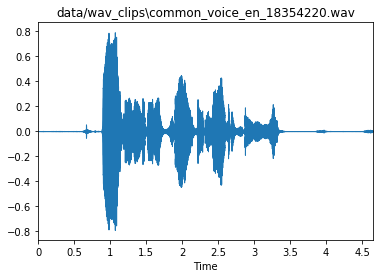

data/wav_clips\common_voice_en_18354220.wav


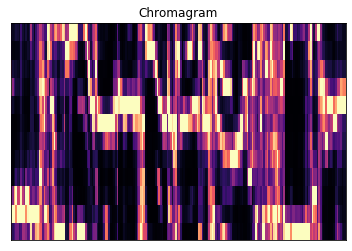

mean 0.32188508
standard deviation 0.32220516


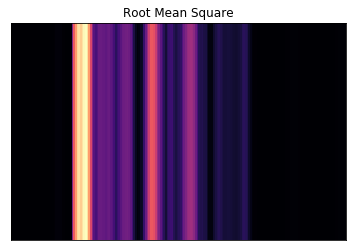

mean 0.049649514
standard deviation 0.071305335


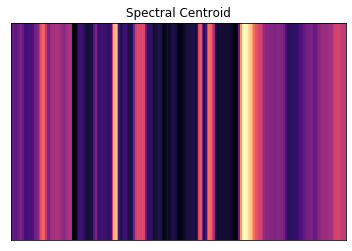

mean 2182.2735971796183
standard deviation 1256.5220340843643


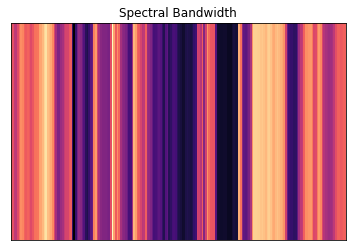

mean 1690.6732508558334
standard deviation 634.1430690052849


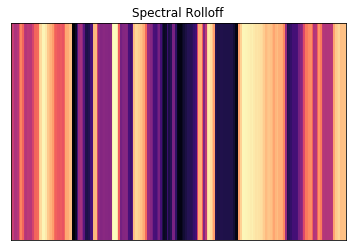

mean 3858.0322265625
standard deviation 2011.475348802791


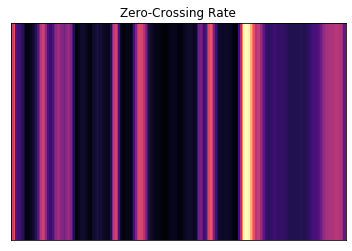

mean 0.14682932991293532
standard deviation 0.11118617681317494


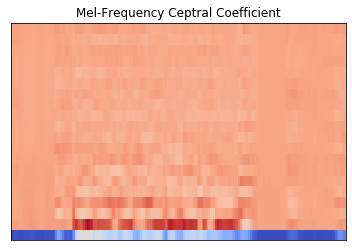

mean -21.812998
standard deviation 93.84438


In [76]:
present_values(df.iloc[0,:])

In [50]:
play_sound(df.iloc[1,:])

DOESN'T WORK


FileNotFoundError: [Errno 2] No such file or directory: 'E:\\IDS Project\\IDS-Project\\Datasets\\wav_clips\\common_voice_en_10091130.wav'

# Modelling

In [67]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
plt.style.use('ggplot')

ModuleNotFoundError: No module named 'mathplotlib'

In [54]:
df = pd.read_csv(output_pathname, encoding="utf-8", sep="\t")
df

,up_votes,down_votes,path,age,gender,accent,chroma_stft,rms,spec_cent,spec_bw,rolloff,zcr,mfcc
0,2,0,Datasets/wav_clips/common_voice_en_10091129.wav,fifties,male,us,0.472234,0.024861,2307.869775,2132.580959,4797.588375,0.136395,-24.520874
1,2,0,Datasets/wav_clips/common_voice_en_10091130.wav,fifties,male,us,0.415472,0.049218,1716.522632,1573.969255,3361.978055,0.098426,-17.076149
2,4,0,Datasets/wav_clips/common_voice_en_10563.wav,thirties,other,us,0.497167,0.014763,3081.801988,2350.760264,5792.458357,0.366476,-26.730108
3,4,0,Datasets/wav_clips/common_voice_en_10564.wav,thirties,other,us,0.390783,0.038026,2731.799814,2045.142584,5051.226239,0.216953,-22.359816
4,2,0,Datasets/wav_clips/common_voice_en_10410522.wav,twenties,male,us,0.481844,0.010068,3518.683239,2802.146680,6893.528353,0.217115,-24.592739
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2302,2,0,Datasets/wav_clips/common_voice_en_10209062.wav,fifties,female,us,0.439742,0.033243,2970.832932,2662.461360,6184.766602,0.167612,-22.828602
2303,2,0,Datasets/wav_clips/common_voice_en_10209063.wav,fifties,female,us,0.399398,0.026217,2760.807520,2266.275394,5187.672335,0.177096,-21.018087
2304,2,0,Datasets/wav_clips/common_voice_en_10209065.wav,fifties,female,us,0.388222,0.024172,2230.666062,2299.027168,4676.918096,0.113927,-20.731462
2305,2,0,Datasets/wav_clips/common_voice_en_10209066.wav,fifties,female,us,0.439761,0.021787,2918.167471,2388.274420,5495.593766,0.187932,-19.918543


# Normalized standard deviation

In [156]:
df.mean()/df.std() #Standard deviation compared to mean

up_votes       1.714286
down_votes     0.369948
chroma_stft    7.488636
rms            1.298474
spec_cent      4.092883
spec_bw        5.362939
rolloff        4.008697
zcr            2.839174
mfcc          -3.046343
dtype: float64

# Data Balance

In [157]:
def distribution_plotter(plot_data,feature):
    counts = plot_data[feature].value_counts()
    counts = counts/sum(counts)
    counts.plot(kind="bar")
    plt.title(feature + " distribution")
    plt.show()
    

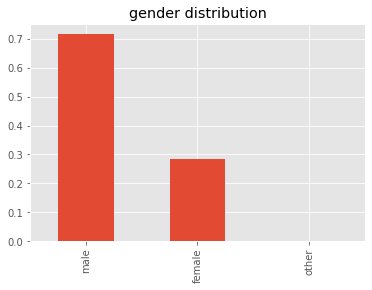

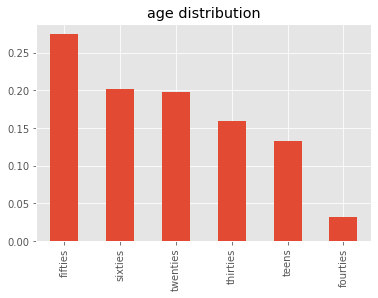

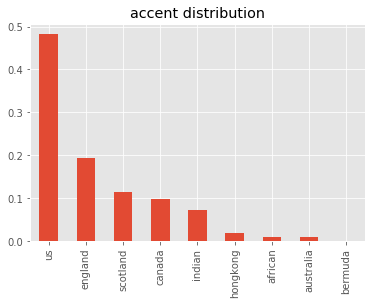

In [158]:
distribution_plotter(df,"gender")
distribution_plotter(df,"age")
distribution_plotter(df,"accent")

### Balancing the Data

In [177]:
minimum_count = 100
data_gender = df.copy()
data_age = df.copy()
data_accent = df.copy()

In [178]:
def dataBalancer(unbalanced_data,feature,floor):
    
    # Removing feature categories that are too small to predict
    counts = unbalanced_data[feature].value_counts()
    for index, value in counts.iteritems():
        if (value < floor):
            unbalanced_data = unbalanced_data[unbalanced_data[feature] != index]
    
    # Taking the largest possible sample of each feature category so that they would be balanced
    counts = unbalanced_data[feature].value_counts()
    lowest_count = min(counts)
    balanced_data = unbalanced_data.copy().head(0)
    for index, value in counts.iteritems():
        index_sample = unbalanced_data[unbalanced_data[feature] == index].sample(lowest_count)
        balanced_data = balanced_data.append(index_sample,ignore_index=True,sort=False)
    
    return balanced_data
    

In [179]:
data_gender = dataBalancer(data_gender,"gender",minimum_count)
data_age = dataBalancer(data_age,"age",minimum_count)
data_accent = dataBalancer(data_accent,"accent",minimum_count)

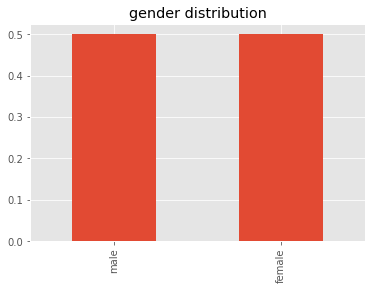

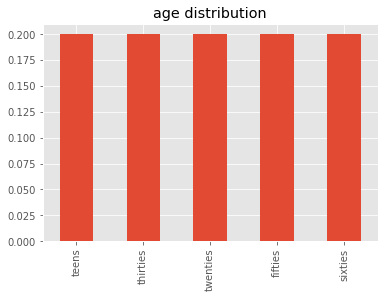

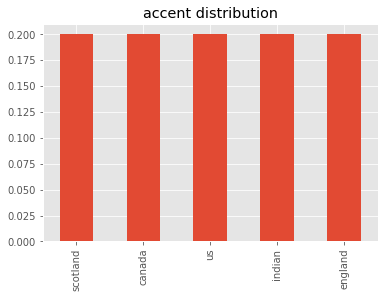

In [182]:
distribution_plotter(data_gender,"gender")
distribution_plotter(data_age,"age")
distribution_plotter(data_accent,"accent")

# Visualization

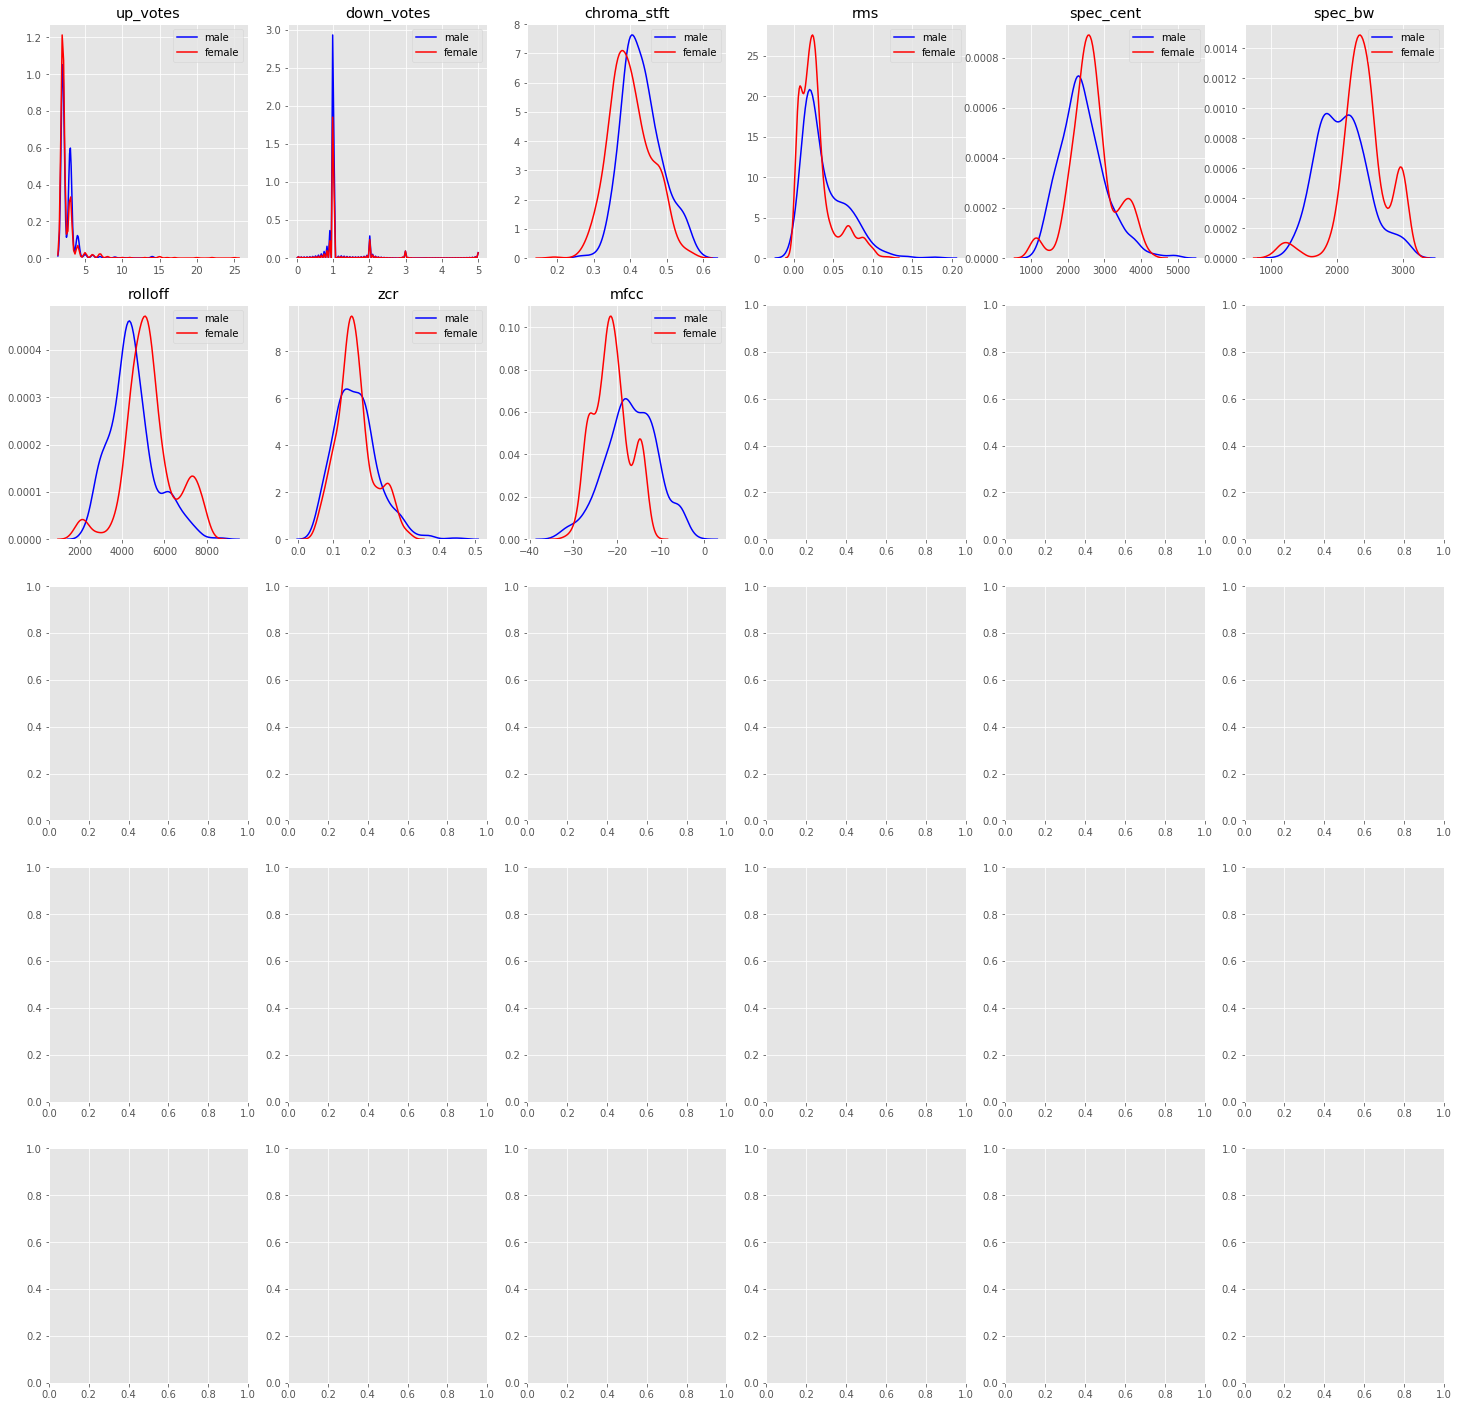

In [201]:
data = data_gender.copy()
data = data.drop(["path"],axis=1)
data = data.drop(["age"],axis=1)
data = data.drop(["accent"],axis=1)
plt.subplots(5,6,figsize=(25,25))
male_subset = data.loc[data["gender"] == "male"]
female_subset = data.loc[data["gender"]=="female"]
data = data.drop(["gender"],axis=1)
i = 1
for column in data.columns:
    plt.subplot(5,6,i)
    plt.title(column)
    sns.kdeplot(male_subset[column],color="blue",label="male")
    sns.kdeplot(female_subset[column],color="red",label="female")
    i += 1
plt.show()

# Creating some models and comparing them

In [192]:
df = data_gender.copy()

In [193]:
X_train, X_test, y_train, y_test = train_test_split(df[["chroma_stft","rms","spec_cent","spec_bw","rolloff","zcr","mfcc"]],df.gender,train_size=0.7)

In [194]:
#Decision tree
dct = DecisionTreeClassifier(criterion='entropy').fit(X_train, y_train)
dct_prediction = dct.predict(X_test)
print("Decision tree accuracy: "+str(accuracy_score(y_test,dct_prediction)))

Decision tree accuracy: 0.8142493638676844


In [195]:
#Random forest
rf = RandomForestClassifier(n_estimators=1000,max_depth=4).fit(X_train, y_train)
rf_prediction = rf.predict(X_test)
print("Random Forest accuracy: "+str(accuracy_score(y_test,rf_prediction)))

Random Forest accuracy: 0.8702290076335878


In [196]:
#SVM linear
svm_linear = SVC(kernel='linear',probability=True).fit(X_train,y_train)
svm_linear_prediction = svm_linear.predict(X_test)
print("SVM linear: "+str(accuracy_score(y_test,svm_linear_prediction)))

SVM linear: 0.7379134860050891


In [197]:
# SVM POLY
#svm_poly = SVC(kernel='poly', degree=2 ,gamma='auto',probability=True).fit(X_train,y_train)
#svm_poly_prediction = svm_poly.predict(X_test)
#print("SVM poly: "+str(accuracy_score(y_test,svm_poly_prediction)))

In [198]:
# SVM RBF
#svm_rbf = SVC(kernel='rbf',gamma='auto',probability=True).fit(X_train,y_train)
#svm_rbf_prediction = svm_rbf.predict(X_test)
#print("SVM RBF: "+str(accuracy_score(y_test,svm_rbf_prediction)))

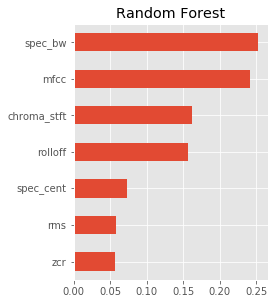

In [199]:
plt.subplots(figsize=(16, 16))
x = np.arange(-5,5,0.25)
y = np.arange(-5,5,0.25)
xx, yy = np.meshgrid(x, y)
df = pd.DataFrame({'x':xx.flatten(),'y':yy.flatten()})


feature_importances_rf = pd.Series(rf.feature_importances_, index= X_train.columns)
plt.subplot(3,4,1)
plt.title('Random Forest')
feature_importances_rf.sort_values().plot(kind='barh')

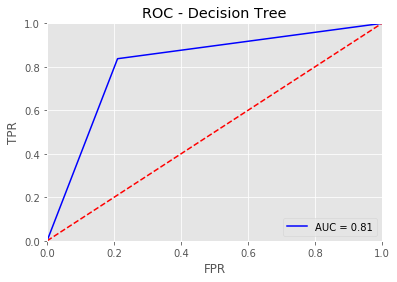

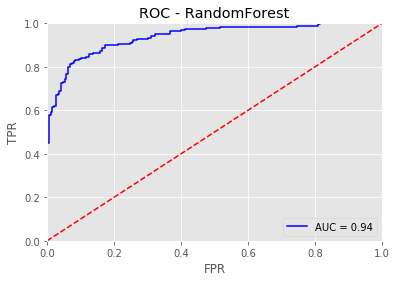

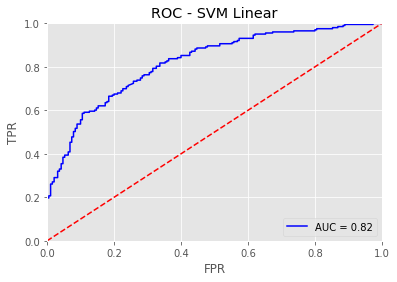

In [200]:
#WORK IN PROGRESS - ROC (https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python)
val = y_test.to_frame()
probs = dct.predict_proba(X_test)
probs = probs[:,1]
fpr,tpr,thresholds = metrics.roc_curve(val,probs,pos_label="male")
roc_auc = metrics.auc(fpr, tpr)
# ROC PLOT
plt.title('ROC - Decision Tree')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()


val = y_test.to_frame()
probs = rf.predict_proba(X_test)
probs = probs[:,1]
fpr,tpr,thresholds = metrics.roc_curve(val,probs,pos_label="male")
roc_auc = metrics.auc(fpr, tpr)
# ROC PLOT
plt.title('ROC - RandomForest')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

val = y_test.to_frame()
probs = svm_linear.predict_proba(X_test)
probs = probs[:,1]
fpr,tpr,thresholds = metrics.roc_curve(val,probs,pos_label="male")
roc_auc = metrics.auc(fpr, tpr)
# ROC PLOT
plt.title('ROC - SVM Linear')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

In [202]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.optimizers import SGD

In [ ]:
def neural_network(hidden_size=5,learning_rate=0.1,momentum=0.9,weights=None):
    
    # One feature per sample
    x = Input((1,))

    # 5 hidden nodes with sigmoid as activation function
    h = Dense(hidden_size,activation='sigmoid',bias_initializer='random_uniform')(x)

    # One output with linear activation function.
    out = Dense(1,activation='linear',bias_initializer='random_uniform')(h)

    # Define a model
    model = Model(inputs=[x],outputs=[out])

    # Stochastic gradient descent with the specificed
    # learning rate and momentum.
    optimizer = SGD(lr=learning_rate,momentum=momentum)

    # Compile the model to generate the computation graph
    model.compile(optimizer=optimizer,loss='mse')
    if weights is not None:
        model.set_weights(weights)
        
    return model